In [ ]:
!pip install http://h2o-release.s3.amazonaws.com/h2o/master/3961/Python/h2o-3.13.0.3961-py2.py3-none-any.whl

# GPU Performance Test: H2O - XGBoost on GPU

![GPU vs CPU](https://s18.postimg.org/ataodekvt/GPU_vs_CPU.jpg)

## 1. Import the H2O Library and its XGBoost Estimator

In [5]:
import h2o
from h2o.estimators.xgboost import H2OXGBoostEstimator

## 2. Connect to a Running H2O instance or start a new one

In [6]:
h2o.connect(ip="35.185.91.179")

Connecting to H2O server at http://35.185.91.179:54321... successful.


H2O cluster uptime:,35 mins 52 secs
H2O cluster version:,3.13.0.318
H2O cluster version age:,23 days
H2O cluster name:,olmsteadbrett
H2O cluster total nodes:,1
H2O cluster free memory:,1.508 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"locked, healthy"
H2O connection url:,http://35.185.91.179:54321
H2O connection proxy:,None


<H2OConnection to http://35.185.91.179:54321, session _sid_a14a>

## 3. Load Some Data From an Amazon S3 Bucket

In [7]:
# Import some data from Amazon S3
h2oDF = h2o.import_file("https://s3-us-west-1.amazonaws.com/dsclouddata/LendingClubData/LoansGoodBad.csv")

# Stratified Split into Train/Test
stratsplit = h2oDF["Bad_Loan"].stratified_split(test_frac=0.3, seed=12349453)
train = h2oDF[stratsplit=="train"]
test = h2oDF[stratsplit=="test"]


Parse progress: |█████████████████████████████████████████████████████████| 100%


## 4. Specify the Response Column

In [8]:
# Identify predictors and response
x = train.columns
y = "Bad_Loan"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
train.head(5)

RowID,Loan_Amount,Term,Interest_Rate,Employment_Years,Home_Ownership,Annual_Income,Verification_Status,Loan_Purpose,State,Debt_to_Income,Delinquent_2yr,Revolving_Cr_Util,Total_Accounts,Bad_Loan,Longest_Credit_Length
2,2500,60 months,15.27,0.5,RENT,30000,VERIFIED - income source,car,GA,1,0,9.4,4,BAD,12
3,2400,36 months,15.96,10,RENT,12252,not verified,small_business,IL,8.72,0,98.5,10,GOOD,10
4,10000,36 months,13.49,10,RENT,49200,VERIFIED - income source,other,CA,20,0,21,37,GOOD,15
5,5000,36 months,7.9,3,RENT,36000,VERIFIED - income source,wedding,AZ,11.2,0,28.3,12,GOOD,7
6,3000,36 months,18.64,9,RENT,48000,VERIFIED - income source,car,CA,5.35,0,87.5,4,GOOD,4


## 5. Train an XGBoost Model using GPU

In [10]:
%%time
XGB_GPU = H2OXGBoostEstimator(model_id="XGB_on_GPU", ntrees=350, max_depth=9, learn_rate=0.05, backend="gpu", gpu_id=0)
XGB_GPU.train(x=x, y=y, training_frame=train, validation_frame=test)
print "Accuracy AUC: " + str(XGB_GPU.auc())

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Accuracy AUC: 0.867577894363
CPU times: user 208 ms, sys: 32 ms, total: 240 ms
Wall time: 16.4 s


## 6. Train an XGBoost Model using CPU

In [60]:
%%time
XGB_CPU = H2OXGBoostEstimator(model_id="XGB_on_CPU", ntrees=350, max_depth=9, learn_rate=0.05, backend="cpu")
XGB_CPU.train(x=x, y=y, training_frame=train, validation_frame=test)
print "Accuracy AUC: " + str(XGB_CPU.auc())

xgboost Model Build progress: |███████████████████████████████████████████| 100%
CPU times: user 644 ms, sys: 68 ms, total: 712 ms
Wall time: 3min 27s


## 7. Which Option is Faster? Which Option Costs Less?

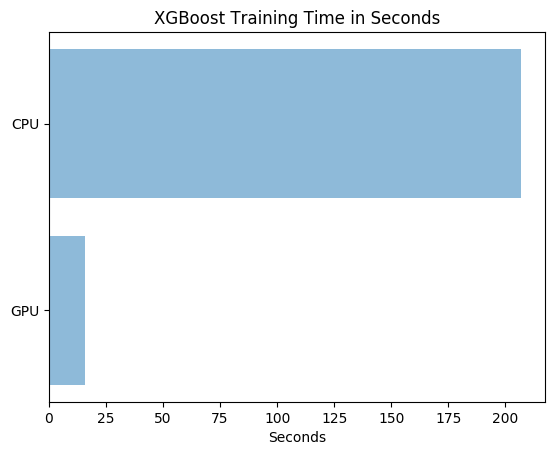

In [12]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('GPU', 'CPU')
y_pos = np.arange(len(objects))
seconds = [16,207]
 
plt.barh(y_pos, seconds, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Seconds')
plt.title('XGBoost Training Time in Seconds')
 
plt.show()